In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import histogram
import os
os.makedirs('./plot', exist_ok=True)

254


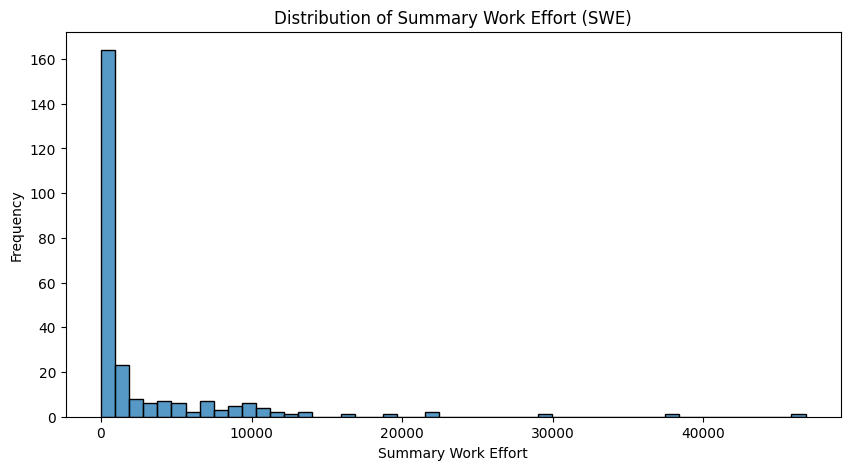

In [30]:
# Importing ISBG as dataframe
ISBG = pd.read_excel("./data/ISBSG-whole.xlsx",header=3)
# ISBG.set_index("Project ID", inplace=True)

cols_needed = ['Max Team Size','COSMIC Read','COSMIC Write','COSMIC Entry','COSMIC Exit','Functional Size','Project Elapsed Time','Development Platform','Primary Programming Language','Summary Work Effort']
ISBG_interest = ISBG[cols_needed]
ISBG_interest.head()

df_clean = ISBG_interest.dropna(subset=["COSMIC Read", "COSMIC Write", "COSMIC Exit", "COSMIC Entry"])
print(len(df_clean))
plt.figure(figsize=(10,5))
sns.histplot(df_clean['Summary Work Effort'], kde=False, bins=50)  # Set bins and kde to False

plt.title('Distribution of Summary Work Effort (SWE)')
plt.xlabel('Summary Work Effort')
plt.ylabel('Frequency')
plt.savefig('./plot/dfCleanhistogram.svg')
plt.show()

df_clean = df_clean.dropna(subset=['Summary Work Effort'])


In [31]:
# Log-transform target variable before split
y_clean = np.log(df_clean["Summary Work Effort"] + 1)
X_clean = df_clean.drop(columns=["Summary Work Effort"])

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# Separate numeric and categorical columns
num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(exclude='number').columns

# Impute numeric values using KNN (fit only on training data)
from sklearn.impute import KNNImputer
imputer_num = KNNImputer(n_neighbors=5)
X_num_train = pd.DataFrame(imputer_num.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_num_test = pd.DataFrame(imputer_num.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

# Impute categorical values using most frequent strategy (fit only on training data)
from sklearn.impute import SimpleImputer
imputer_cat = SimpleImputer(strategy="most_frequent")
X_cat_train = pd.DataFrame(imputer_cat.fit_transform(X_train[cat_cols]), columns=cat_cols, index=X_train.index)
X_cat_test = pd.DataFrame(imputer_cat.transform(X_test[cat_cols]), columns=cat_cols, index=X_test.index)

# Combine imputed columns
X_train_imputed = pd.concat([X_num_train, X_cat_train], axis=1)
X_test_imputed = pd.concat([X_num_test, X_cat_test], axis=1)

# Scale numeric columns (fit on training data only)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_num_train_scaled = pd.DataFrame(scaler.fit_transform(X_num_train), columns=num_cols, index=X_train.index)
X_num_test_scaled = pd.DataFrame(scaler.transform(X_num_test), columns=num_cols, index=X_test.index)

# Combine scaled numeric and imputed categorical
X_train_final = pd.concat([X_num_train_scaled, X_cat_train], axis=1)
X_test_final = pd.concat([X_num_test_scaled, X_cat_test], axis=1)

# --- Feature separation for experiments (AFTER preprocessing) ---

# Functional features (numerical, already scaled)
functional_features = ["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"]
X_func_train = X_train_final[functional_features]
X_func_test = X_test_final[functional_features]

# Technical features
tech_features = ["Development Platform", "Primary Programming Language", 
                 "Project Elapsed Time", "Max Team Size"]
tech_cat_cols = ["Development Platform", "Primary Programming Language"]

X_tech_train = X_train_final[tech_features]
X_tech_test = X_test_final[tech_features]

# One-hot encode technical categorical columns
X_tech_train = pd.get_dummies(X_tech_train, columns=tech_cat_cols, drop_first=True)
X_tech_test = pd.get_dummies(X_tech_test, columns=tech_cat_cols, drop_first=True)


In [37]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import shap 

# Define model
dt = DecisionTreeRegressor(random_state=42)
"""""
# Define scoring metrics (on log scale)
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
}

# Run 5-fold cross-validation
cv_results = cross_validate(
    dt,
    X_train,
    y_train,  # log-transformed SWE
    cv=10,
    scoring=scoring,
    return_train_score=False
)

# Show average scores
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")

"""

def evaluate_model(X, y, model=None, label=""):
    if model is None:
        model = DecisionTreeRegressor(random_state=42)
    scoring = {
        'r2': 'r2',
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error),
    }

    results = cross_validate(model, X, y, cv=10, scoring=scoring, return_train_score=False)

    print(f"\n--- {label} ---")
    for metric in scoring:
        scores = results[f'test_{metric}']
        print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")


# Functional features only
evaluate_model(X_func_train, y_train, label="Functional Approach")

# Technical features (with dummy-coded categoricals)
evaluate_model(X_tech_train, y_train, label="Technical Approach")



--- Functional Approach ---
R2 (mean ± std): 0.2307 ± 0.2286
MAE (mean ± std): 1.3134 ± 0.1546
MSE (mean ± std): 2.9481 ± 0.5227

--- Technical Approach ---
R2 (mean ± std): 0.6019 ± 0.1737
MAE (mean ± std): 0.8921 ± 0.1931
MSE (mean ± std): 1.5781 ± 0.6622


In [19]:
from sklearn.neural_network import MLPRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress only the convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define the MLPRegressor model (you can adjust the hyperparameters as needed)
mlp = MLPRegressor(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam', max_iter=1000, random_state=42, early_stopping=False)

# Functional features only
evaluate_model(X_func_train, y_train, model=mlp, label="Functional Approach (MLP)")

# Technical features only
evaluate_model(X_tech_train, y_train, model=mlp, label="Technical Approach (MLP)")



--- Functional Approach (MLP) ---
R2 (mean ± std): 0.5004 ± 0.1742
MAE (mean ± std): 1.1110 ± 0.1760
MSE (mean ± std): 1.9717 ± 0.6424

--- Technical Approach (MLP) ---
R2 (mean ± std): 0.6779 ± 0.1143
MAE (mean ± std): 0.8411 ± 0.1282
MSE (mean ± std): 1.2604 ± 0.3946


In [20]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the XGBoost model
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    colsample_bytree=0.3, 
    learning_rate=0.6,
    max_depth=10, 
    alpha=10, 
    n_estimators=100, 
    verbosity=0, 
    random_state=42
)

# Evaluate functional approach with XGBoost
evaluate_model(X_func_train, y_train, model=xg_reg, label="Functional Approach (XGBoost)")

# Evaluate technical approach with XGBoost
evaluate_model(X_tech_train, y_train, model=xg_reg, label="Technical Approach (XGBoost)")


# Evaluate technical approach without Project Elapsed Time using XGBoost
evaluate_model(
    X_tech_train.drop(columns=['Project Elapsed Time']), 
    y_train, 
    model=xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.3,
        learning_rate=0.3,
        max_depth=10,
        alpha=10,
        n_estimators=100,
        verbosity=0,
        random_state=42
    ),
    label="Technical Approach w/o Project Elapsed Time (XGBoost)"
)



--- Functional Approach (XGBoost) ---
R2 (mean ± std): 0.5825 ± 0.1204
MAE (mean ± std): 1.0100 ± 0.1415
MSE (mean ± std): 1.6513 ± 0.5051

--- Technical Approach (XGBoost) ---
R2 (mean ± std): 0.7141 ± 0.0919
MAE (mean ± std): 0.8399 ± 0.1946
MSE (mean ± std): 1.1631 ± 0.4338

--- Technical Approach w/o Project Elapsed Time (XGBoost) ---
R2 (mean ± std): 0.6538 ± 0.0988
MAE (mean ± std): 0.9204 ± 0.1840
MSE (mean ± std): 1.3828 ± 0.4425
